In [1]:
#This is the notebook for testing the pipeline before pushing any changes
import localnmf 
from localnmf import superpixel_analysis_ring
import os
import numpy as np
import scipy
import scipy.sparse
import torch_sparse
import torch

from localnmf import visualization
from localnmf.visualization import standard_demix_vid_m
import scipy.sparse
import scipy
import matplotlib.pyplot as plt
from localnmf.pmd_video import PMDVideo
%load_ext line_profiler

/data/home/app2139/anaconda3/envs/masknmf_full_pipeline/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_file = "../datasets/decomposition.npz"
data = np.load(input_file, allow_pickle=True)

In [3]:
U_sparse = scipy.sparse.csr_matrix(
        (data['U_data'], data['U_indices'], data['U_indptr']),
        shape=data['U_shape']
    ).tocsr()
order = data.get('fov_order', np.array("C")).item()
shape = data['U_shape']
d1,d2 = data['fov_shape']

R = data['R']
s = data['s']
Vt = data['Vt']
T = Vt.shape[1]
mean_img = data['mean_img']
noise_var_img = data['noise_var_img']
device='cuda'

# Initialize PMD Object which stores the state of the demixing procedure

In [4]:
pmd_video = PMDVideo(U_sparse, R, s, Vt,(d1, d2, T), mean_img, noise_var_img, data_order=order, device=device)

In [5]:
# First pass initialization of neural signals

the time to run the one time only local corr data structure computation is 0.020771503448486328
find superpixels!
find pure superpixels!
prepare iteration!


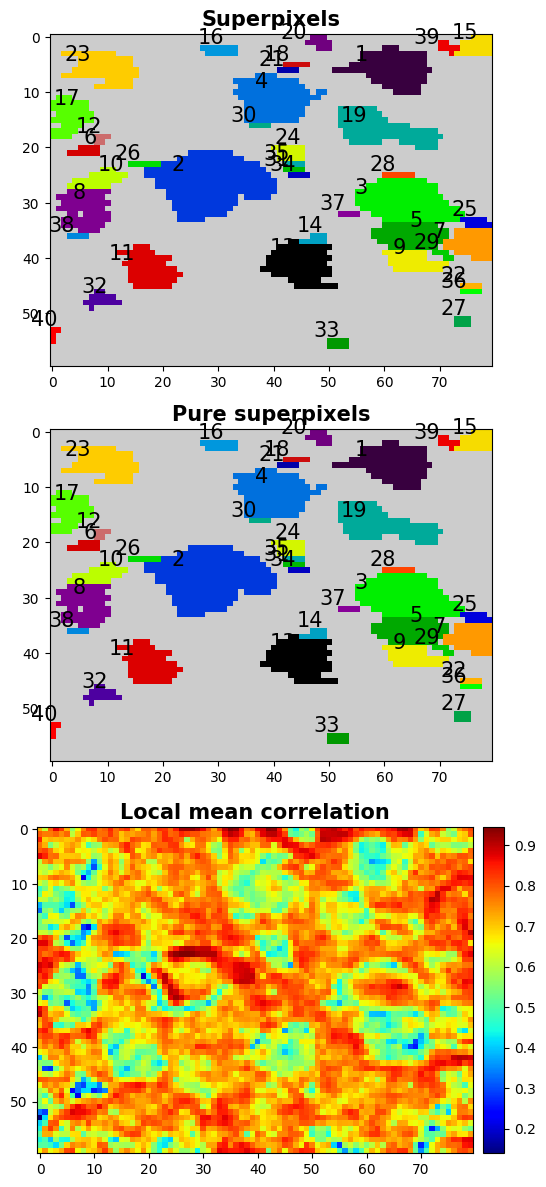

the time to run pure superpixelization is 1.285125494003296


In [5]:
num_plane = 1
cut_off_point = 0.9
residual_cut = 0.1
length_cut = 3
th = 2
pseudo_2 = 0.1

pmd_video.initialize_signals_superpixels(num_plane, cut_off_point, residual_cut, length_cut, th, pseudo_2, \
                                       text =True, plot_en = True)

# Run the demixing procedure

In [6]:
localnmf_params = {
        'init': ['lnmf', 'lnmf', 'lnmf', 'lnmf'],
        'pseudo_2':[0.1, 0.1, 0.1, 0.1],
        'corr_th_fix':0.55,
        'switch_point':5,
        'corr_th_fix_sec':0.7,
        'corr_th_del':0.2,
        'merge_corr_thr':0.7,
        'merge_overlap_thr':0.7,
        'r':20,
        'residual_cut':[0.5, 0.6, 0.6, 0.6],
        'num_plane': 1,
        'patch_size': [100,100],
        'maxiter': 25,
        'update_after':8, 
        'plot_en': False,
        'skips':0,
}

corr_th_fix=localnmf_params['corr_th_fix'] 
switch_point = localnmf_params['switch_point']
corr_th_fix_sec = localnmf_params['corr_th_fix_sec']
corr_th_del = localnmf_params['corr_th_del']

merge_corr_thr= localnmf_params['merge_corr_thr']
merge_overlap_thr= localnmf_params['merge_overlap_thr']
ring_radius =  localnmf_params['r']
pseudo_2 = localnmf_params['pseudo_2']


residual_cut = localnmf_params['residual_cut']
num_plane= localnmf_params['num_plane']
patch_size= localnmf_params['patch_size'] 
plot_en = localnmf_params['plot_en'] 
maxiter= localnmf_params['maxiter']
update_after = localnmf_params['update_after']
skips= localnmf_params['skips'] 
plot_debug = False
denoise = [False for i in range(maxiter)]



from localnmf.superpixel_analysis_ring import update_AC_bg_l2_Y_ring_lowrank
from localnmf.pmd_video import PMDVideo
from localnmf.pmd_video import merge_components, vcorrcoef_resid

from localnmf.regression_update import spatial_update_HALS, temporal_update_HALS, project_U_HALS

with torch.no_grad():

    %lprun -f PMDVideo.support_update_prune_elements_apply_mask a, c, b, W, res, corr_img_all_r, num_list = superpixel_analysis_ring.update_AC_bg_l2_Y_ring_lowrank(pmd_video, maxiter, corr_th_fix, \
                                                                                                           corr_th_fix_sec, corr_th_del, switch_point, skips, \
                                                                                                           merge_corr_thr, merge_overlap_thr, ring_radius, denoise=denoise,\
                                                                                                           plot_en=plot_en, plot_debug=plot_debug, update_after=update_after)
    W_final = W.create_complete_ring_matrix(a)
    fin_rlt = {'U_sparse': pmd_video.U_sparse.cpu().to_scipy(layout='csr'), 'R': pmd_video.R.cpu().numpy(), 'V': pmd_video.V.cpu().numpy(), 'a':a, 'c':c, 'b':b, "W":W_final, \
               'res':res, 'corr_img_all_r':corr_img_all_r, 'num_list':num_list, 'data_order': pmd_video.data_order, 'data_shape':pmd_video.shape};




number of elts in ring is 124
the max of good components is True
time: 0.03188061714172363
time: 0.02601170539855957
time: 0.02547144889831543
time: 0.02540445327758789
time: 0.02536177635192871
time: 0.025515079498291016
time: 0.025394678115844727
mask, support, and deletion update
making dynamic support updates
entering thresholding..
merging components
time: 0.3318777084350586
time: 0.025784015655517578
time: 0.02514481544494629
time: 0.025229930877685547
time: 0.02521800994873047
time: 0.025572538375854492
time: 0.02581191062927246
time: 0.02552938461303711
mask, support, and deletion update
making dynamic support updates
entering thresholding..
merging components
merge[25  3 28]
time: 0.12320804595947266
time: 0.024539947509765625
time: 0.024555683135986328
time: 0.024851083755493164
time: 0.024410486221313477
time: 0.024545907974243164
time: 0.024497509002685547
time: 0.025157451629638672
mask, support, and deletion update
making dynamic support updates
entering thresholding..
me

Timer unit: 1e-09 s

Total time: 0.0801909 s
File: /data/home/app2139/rlocalnmf/localnmf/pmd_video.py
Function: support_update_prune_elements_apply_mask at line 1970

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1970                                               def support_update_prune_elements_apply_mask(self, corr_th_fix, corr_th_del, plot_en):
  1971                                                   
  1972                                                   #Currently using rigid mask
  1973         3      26229.0   8743.0      0.0          print("making dynamic support updates")
  1974         3     679166.0 226388.7      0.8          self.mask_ab = self.a.bool()
  1975         3      13262.0   4420.7      0.0          corr_img_all_r = self.residual_correlation_image.reshape(self.d1, self.d2, -1, order=self.data_order)
  1976         3   64866992.0 21622330.7     80.9          mask_a_rigid = make_mask_dynamic(corr_img_all_r, corr_th_fix, self.mask_ab.cpu().to_de

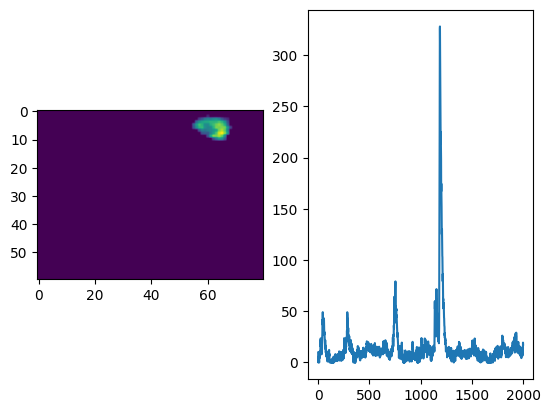

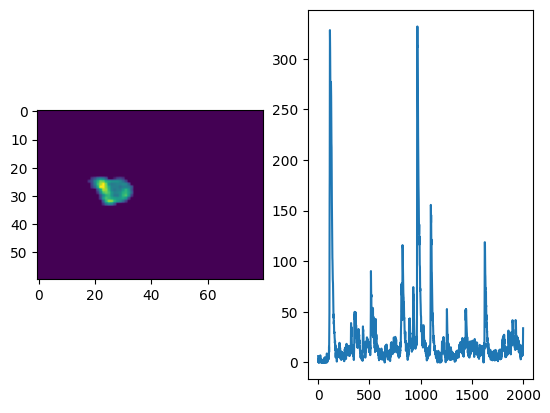

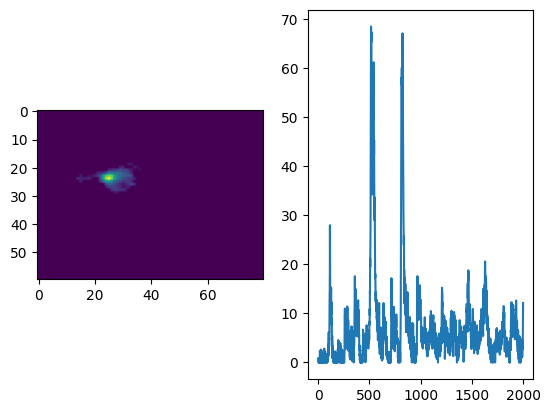

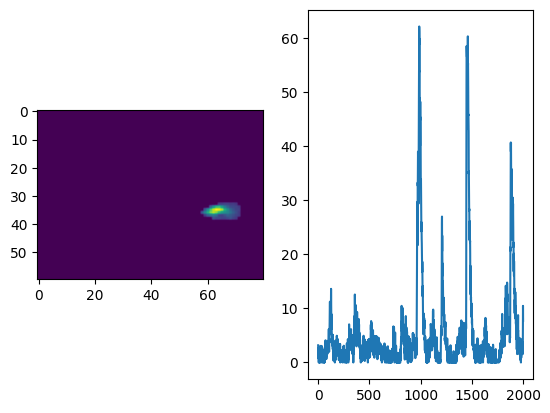

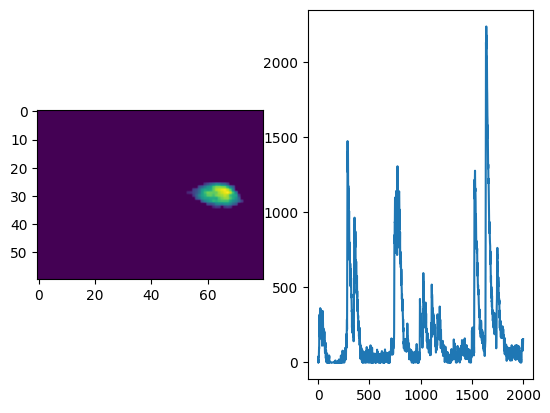

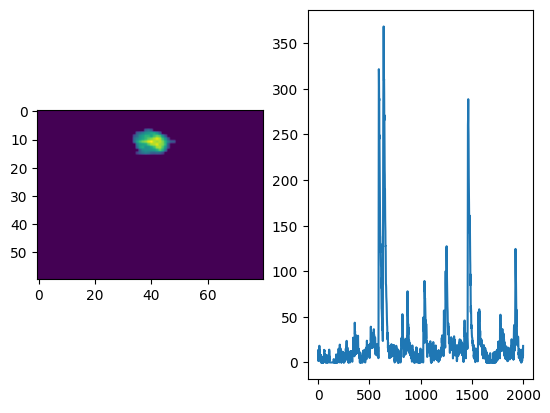

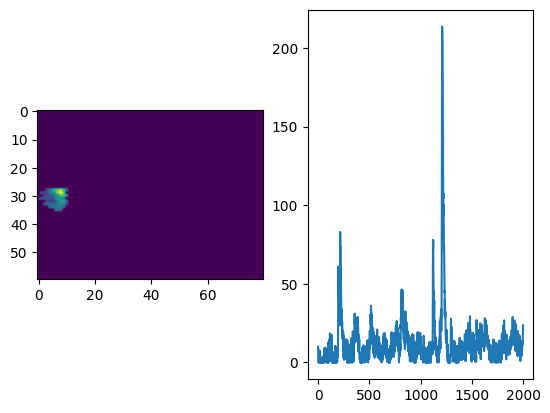

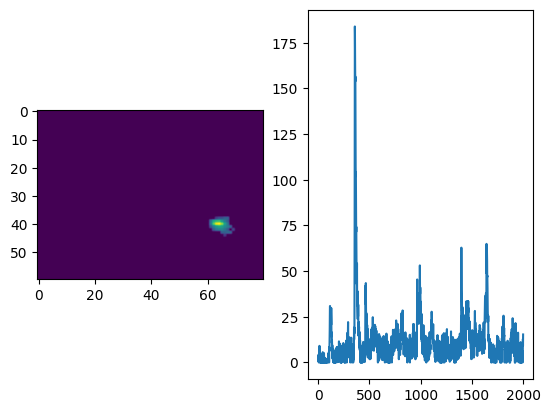

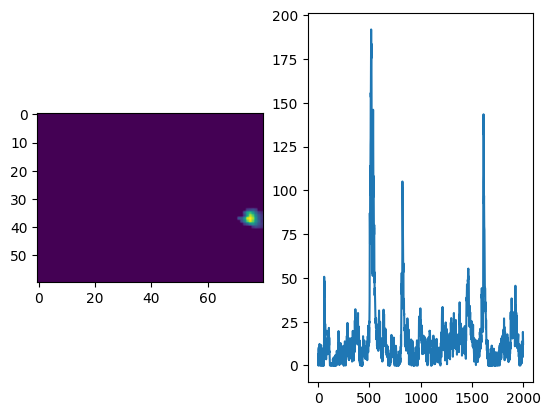

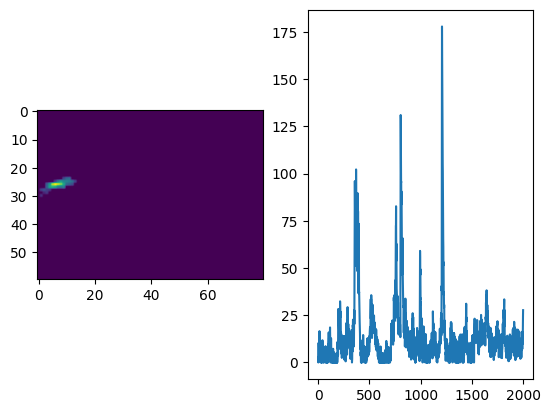

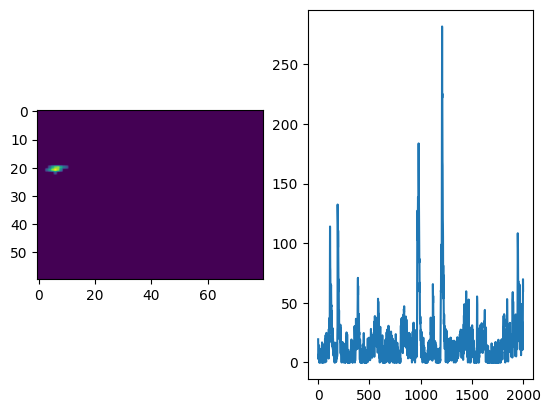

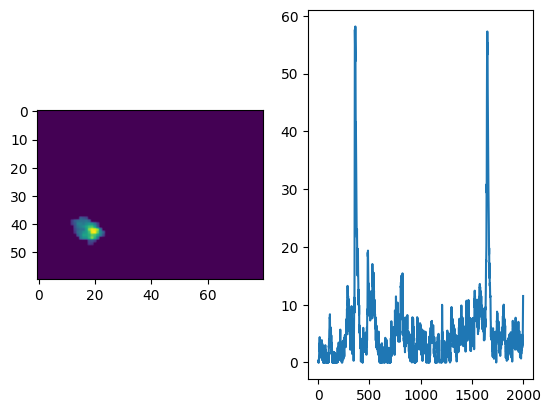

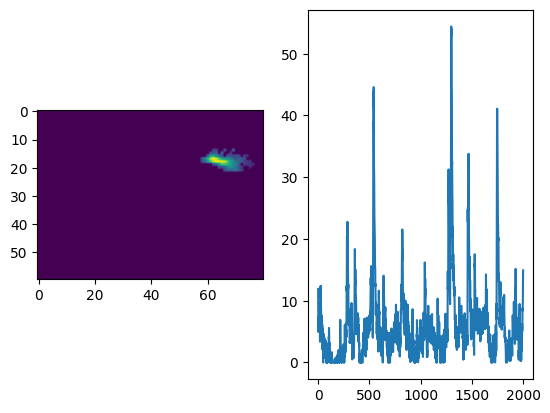

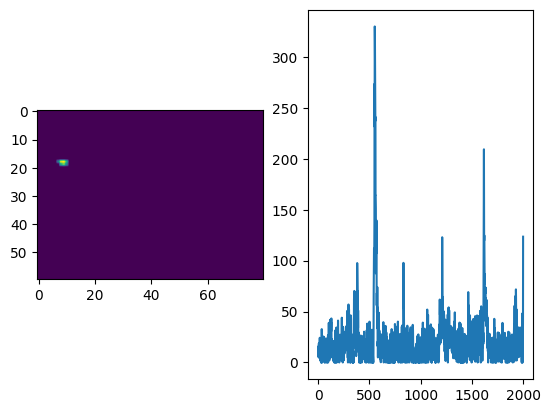

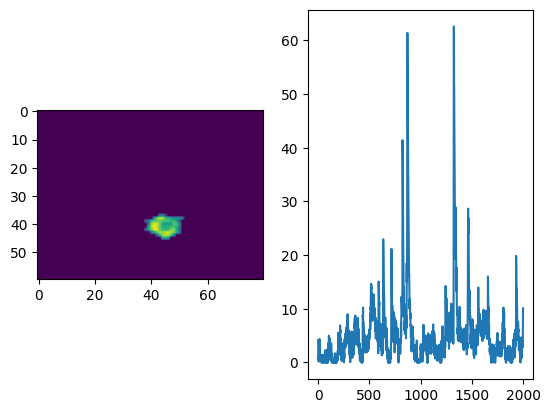

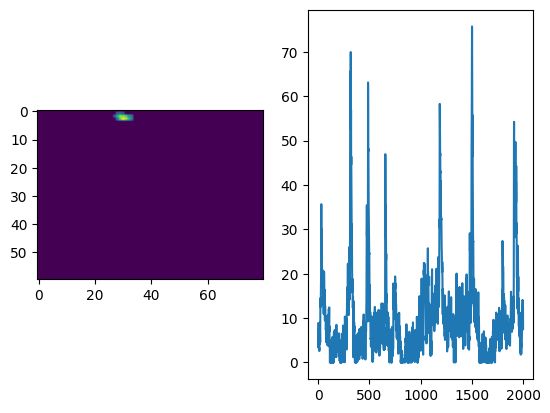

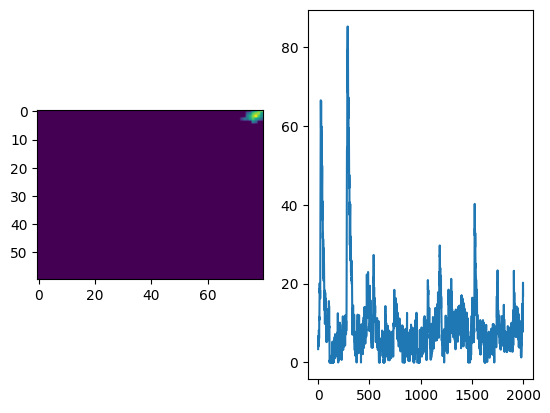

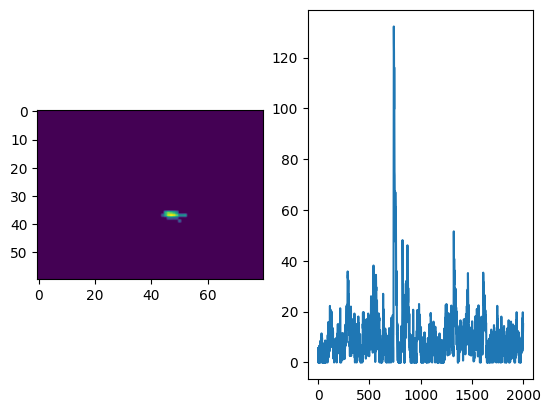

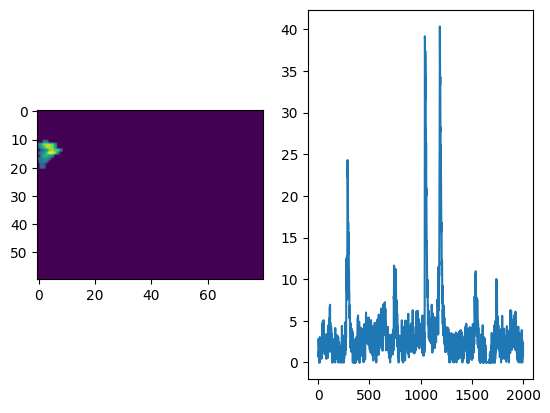

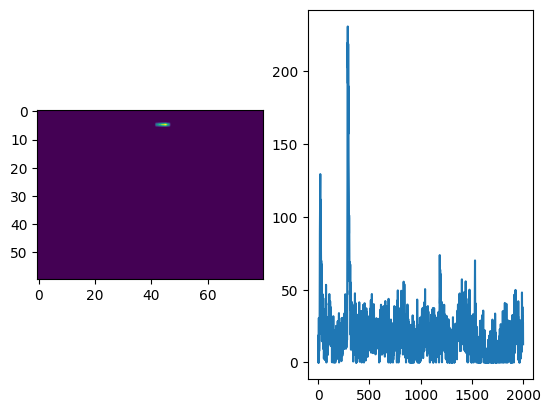

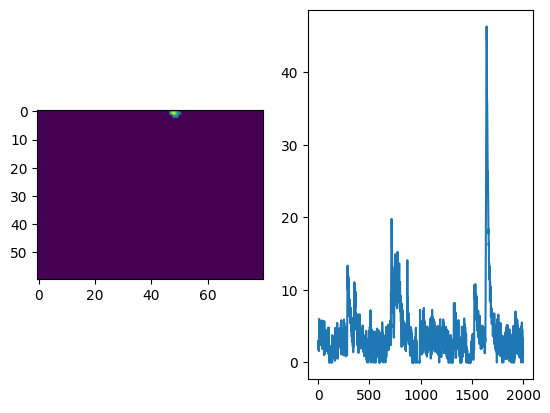

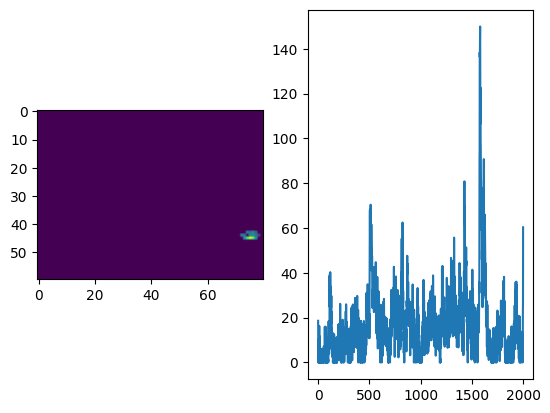

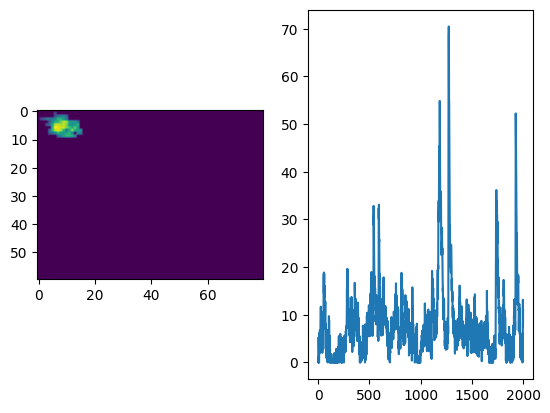

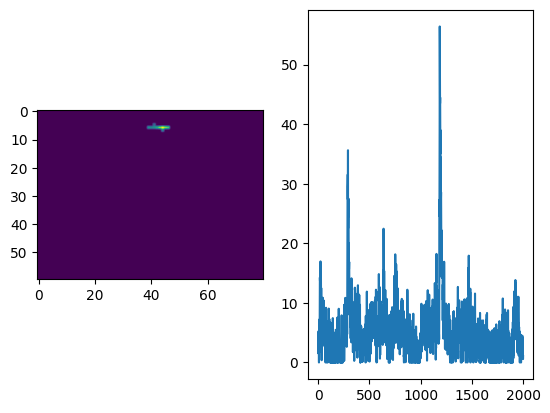

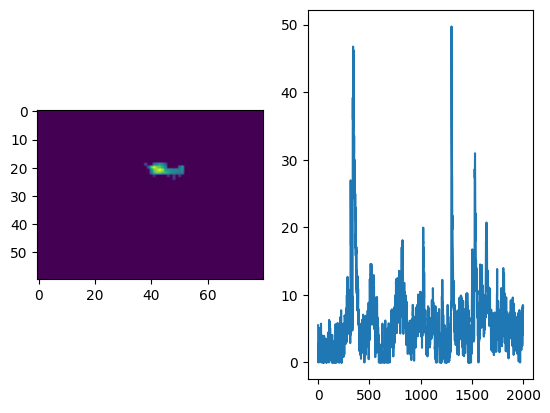

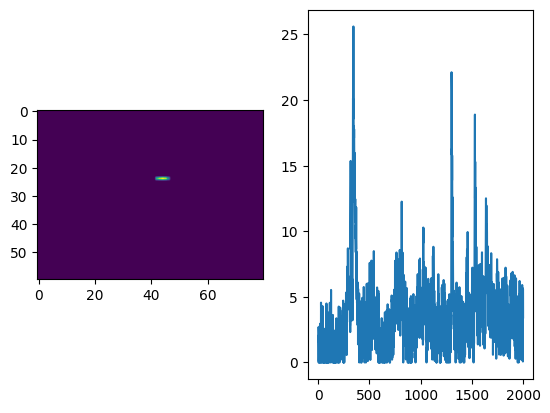

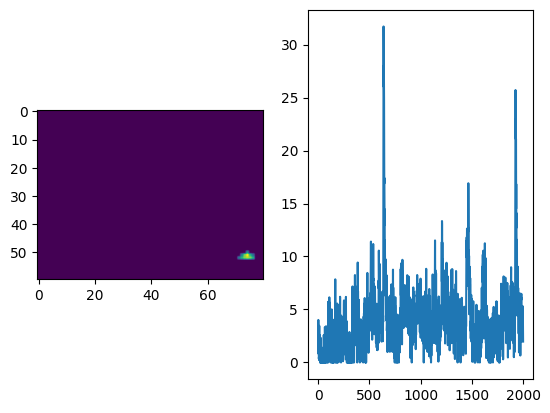

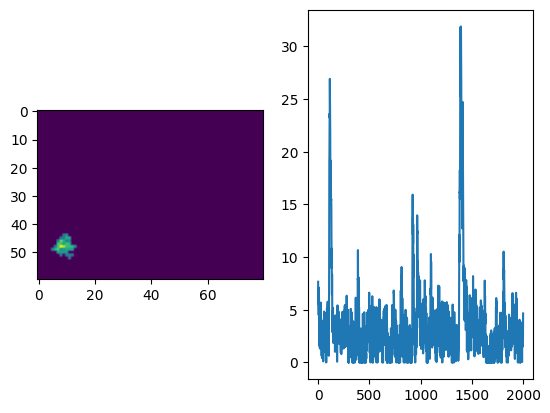

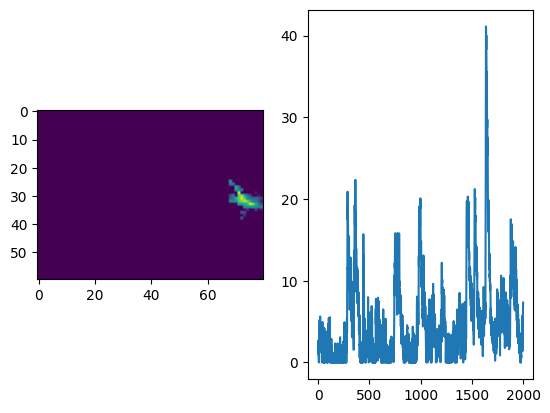

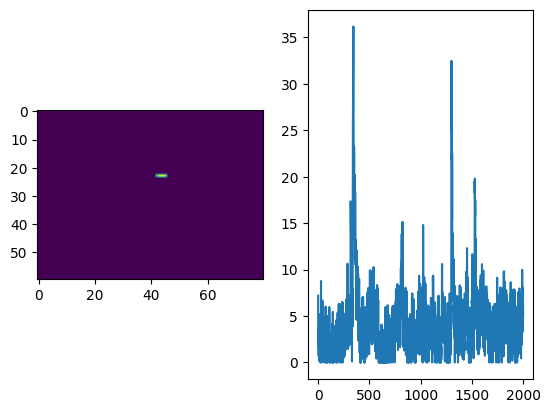

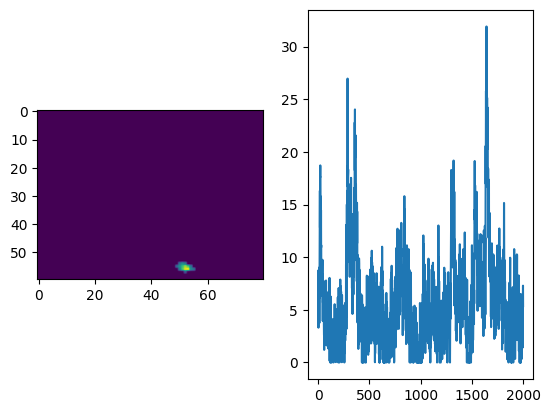

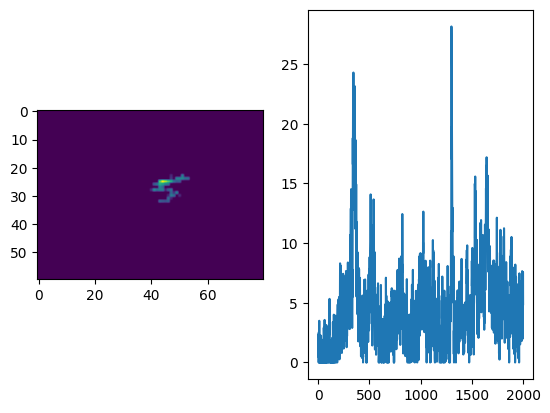

KeyboardInterrupt: 

In [7]:

for k in range(c.shape[1]):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(a[:, k].reshape((60, 80), order=pmd_video.data_order))
    ax[1].plot(c[:, k])
    plt.show()

In [7]:
temp_mat1 = scipy.sparse.random(512*512, 1000, density = 0.05)
temp_mat2 = scipy.sparse.random(512*512, 1000, density = 0.05)

KeyboardInterrupt: 

In [ ]:
temp_sparse1 = torch_sparse.tensor.from_scipy(temp_mat1).to('cuda').float()
temp_sparse2 = torch_sparse.tensor.from_scipy(temp_mat2).to('cuda').float()

In [ ]:
%time output = torch_sparse.matmul(temp_sparse.t(), temp_sparse)
%time output = output.to_dense()

In [ ]:
dense_mat = temp_sparse.to_dense()

In [ ]:
%time output = torch.matmul(dense_mat.t(), dense_mat)

In [ ]:
def synch_run(sparse_mat1, sparse_mat2): 
    inner1 = torch_sparse.matmul(sparse_mat1.t(), sparse_mat1).to_dense()
    inner1 += 1
    
    inner2 = torch_sparse.matmul(sparse_mat2.t(), sparse_mat2).to_dense()
    inner2 += 1
    
    return inner1 + inner2

def async_run(sparse_mat1, sparse_mat2):
    inner1 = torch_sparse.matmul(sparse_mat1.t(), sparse_mat1).to_dense()
    inner2 = torch_sparse.matmul(sparse_mat2.t(), sparse_mat2).to_dense()
    inner2 += 1
    inner1 += 1
    
    return inner1 + inner2




In [ ]:
%time _ = synch_run(temp_sparse1, temp_sparse2)

%time _ =async_run(temp_sparse1, temp_sparse2)

In [ ]:
%time temp_sparse1.to_dense()